In [1]:
# Подключение библиотек и скриптов
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})  # размер шрифта на графиках
%config InlineBackend.figure_format = 'svg'


In [3]:
# функция для анализа результатов предсказания на тренировочном и валидационном датасете
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(20,12))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test prediction')

    plt.show()

In [6]:
# загрузка тестового датасета
test_df = pd.read_csv("test.csv" , delimiter=',')
test_df.tail()


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


In [7]:
# загрузка тренировочного датасета
train_df = pd.read_csv("train.csv" , delimiter=',')
train_df.tail()


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


# train_df.shape

In [5]:
train_df.loc[0]

Id                   14038
DistrictId              35
Rooms                    2
Square             47.9816
LifeSquare         29.4428
KitchenSquare            6
Floor                    7
HouseFloor               9
HouseYear             1969
Ecology_1        0.0890397
Ecology_2                B
Ecology_3                B
Social_1                33
Social_2              7976
Social_3                 5
Healthcare_1           NaN
Helthcare_2              0
Shops_1                 11
Shops_2                  B
Price               184967
Name: 0, dtype: object

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [ ]:
# Мы видим,что количество значений в признаках LifeSquare и Healthcare_1 гораздо меньше количества наблюдений
# Также нам необходимо объекты типа object перевести в числовой

In [9]:
# Анализ и приведение типов
train_df.dtypes


Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [10]:
# Определение категориальных перменных и перевод их в числовые значение,если это необходимо
# Список номинативных переменных
train_df.select_dtypes(include='object').columns.tolist()


['Ecology_2', 'Ecology_3', 'Shops_2']

In [11]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [13]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [14]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [20]:
# перевод категориальных переменных в числовой вид
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)


In [21]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  int64  
 11  Ecology_3      10000 non-null  int64  
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [22]:
# Признак 'Id' перенесём в строчны тип ,так как он не обладает для нас полезной информацией
train_df['Id'] = train_df['Id'].astype(str)

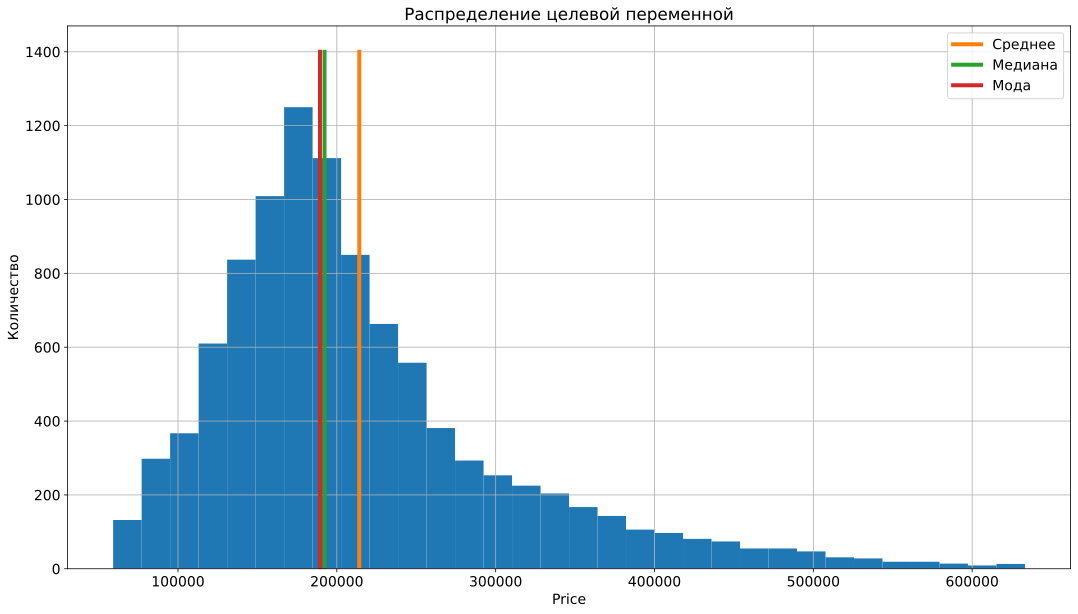

In [25]:
# Распределение целевой переменной
target_name = 'Price'
target_mean = round(train_df[target_name].mean(), 2)
target_median = train_df[target_name].median()
# Округлим значение моды до 100.Мода-=наиболее часто встречающееся значениие целевой переменной
target_mode = (train_df[target_name]//100 * 100).mode()

plt.figure(figsize = (18, 10))

train_df.Price.hist(bins=32)

y = np.linspace(0, 1400, 10)

plt.plot([target_mean] * 10, y, label='Среднее', linewidth=4)
plt.plot([target_median] * 10, y, label='Медиана', linewidth=4)
plt.plot([target_mode] * 10, y, label='Мода', linewidth=4)

plt.ylabel('Количество')
plt.xlabel(target_name)
plt.legend()

plt.title('Распределение целевой переменной')
plt.show()


In [37]:
# Определяем пропуски в датасете и их количество
train_df.isna().sum()



Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

In [38]:
# Определим разницу между общей площадью и площадью кухни


delta = (train_df['LifeSquare'].isna()) \
        & (~train_df['Square'].isna())  \
        & (~train_df['KitchenSquare'].isna())
#Заполним пропуски разницей delta
train_df.loc[delta, 'LifeSquare'] = train_df.loc[delta, 'Square'] - train_df.loc[delta, 'KitchenSquare']

In [36]:
# Признак Healthcare_1 является второстепенным для нашего прогноза.Поскольку пустых значений много,то проще от него избавиться

train_df.drop('Healthcare_1', axis=1, inplace=True)

KeyError: "['Healthcare_1'] not found in axis"

In [43]:
# Разбиение на train и test
X = train_df.drop(columns=target_name)
y = train_df[target_name]


In [44]:
# Разбиваем данные на тренировочные и валидационные
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=25)

In [45]:
# Построение базовой модели
rf_model = RandomForestRegressor(random_state=28, criterion='mse')
rf_model.fit(X_train,y_train)


RandomForestRegressor(random_state=28)

Train R2:	0.96
Test R2:	0.746


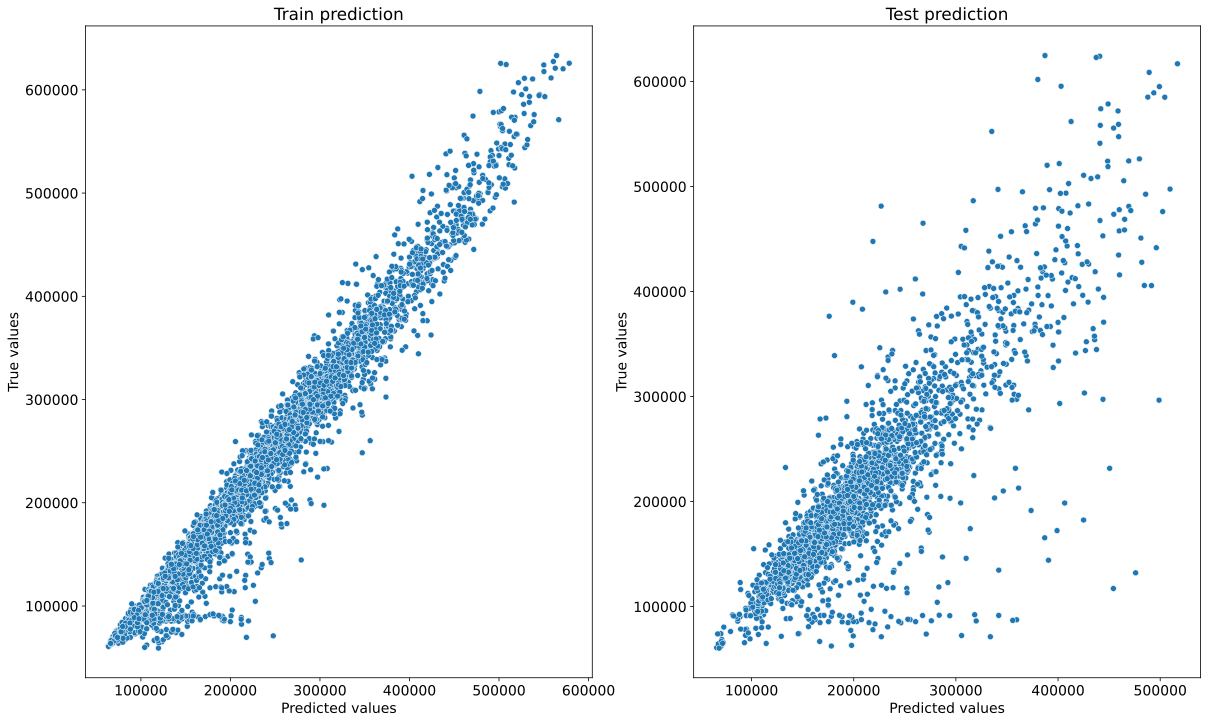

In [48]:
# Получение базовой оценки
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)


In [49]:
# Оценка базовой модели
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=25))
cv_score

array([0.72274141, 0.6801237 , 0.70778186, 0.75293053, 0.71543698])

In [50]:
cv_score.mean()

0.7158028957255095